In [1]:
import numpy as np
import rasterio

# Open the clipped Red band
with rasterio.open("../src/mauritania.tif") as red_src:
    red = red_src.read(1).astype(float)
    red_meta = red_src.meta.copy()

# Open the clipped NIR band
with rasterio.open("../src/mauritania.tif") as nir_src:
    nir = nir_src.read(1).astype(float)
    nir_meta = nir_src.meta.copy()

# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-6)  # Add small epsilon to avoid /0

# Prepare metadata for NDVI output
ndvi_meta = red_meta
ndvi_meta.update({
    "count": 1,
    "dtype": "float32"
})

# Write NDVI to a new file
with rasterio.open("../src/ndvi_mauritania.tif", "w", **ndvi_meta) as dst:
    dst.write(ndvi.astype(np.float32), 1)


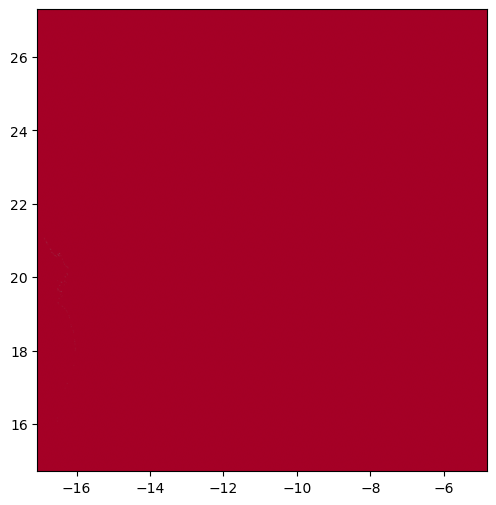

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

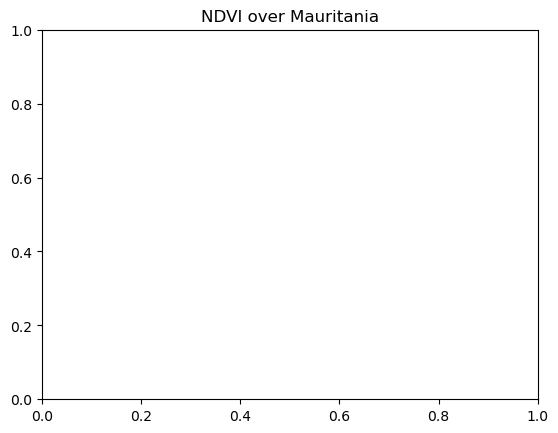

In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the NDVI raster
with rasterio.open("../src/ndvi_mauritania.tif") as src:
    ndvi_data = src.read(1)

plt.figure(figsize=(8,6))
show(ndvi_data, transform=src.transform, cmap='RdYlGn')
plt.title("NDVI over Mauritania")
plt.colorbar()
plt.show()


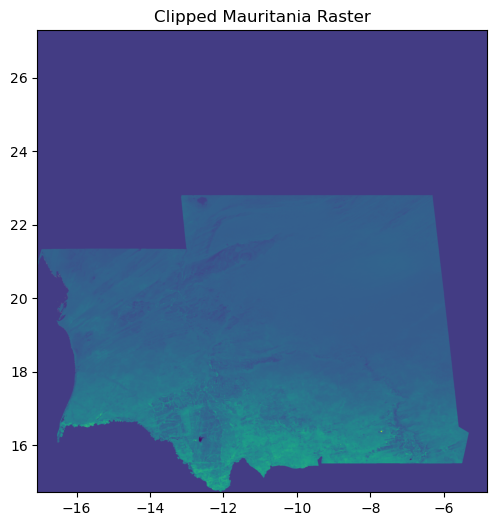

In [3]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open your clipped raster
with rasterio.open("../src/mauritania.tif") as src:
    data = src.read(1)  # Reading the first band

fig, ax = plt.subplots(figsize=(8, 6))

# rasterio.plot.show can accept an Axes argument
# It returns None by default, so we won't get a handle for colorbar
# We can either rely on a direct matplotlib approach (see Option 2)
show(data, ax=ax, transform=src.transform, cmap='viridis')

# Attempting plt.colorbar() here will fail because there's no mappable object returned
plt.title("Clipped Mauritania Raster")
plt.show()


C:\Users\loren\AppData\Local\Temp\ipykernel_23520\896290877.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn').copy()  # Good for vegetation indices


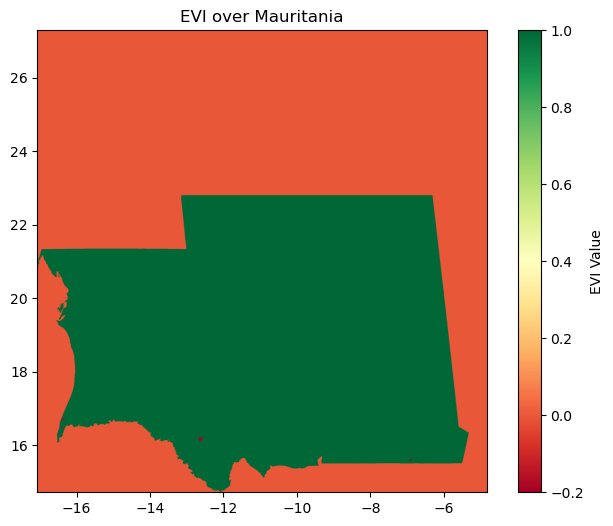

In [7]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib as mpl
from rasterio.plot import show

# Open the clipped EVI raster
with rasterio.open("../src/mauritania.tif") as src:
    evi_data = src.read(1).astype(float)
    transform = src.transform

# (Optional) If the dataset is integer-based MODIS EVI, apply scale factor:
# evi_data = evi_data * 0.0001

# (Optional) Mask NoData if needed
nodata_val = src.nodata
if nodata_val is not None:
    mask = np.isclose(evi_data, nodata_val)
else:
    mask = np.zeros_like(evi_data, dtype=bool)

evi_data_masked = np.ma.masked_array(evi_data, mask=mask)

# Create a colormap that shows masked pixels in black
cmap = plt.cm.get_cmap('RdYlGn').copy()  # Good for vegetation indices
cmap.set_bad('black')                   # Masked pixels -> black

# Plot using rasterio.plot.show, but we won't get a direct handle for the colorbar
fig, ax = plt.subplots(figsize=(8,6))
show(
    evi_data_masked,
    ax=ax,
    transform=transform,
    cmap=cmap,
    vmin=-0.2,  # typical EVI lower bound
    vmax=1.0    # typical EVI upper bound
)

ax.set_title("EVI over Mauritania")

# Manually create a ScalarMappable for the colorbar
norm = mpl.colors.Normalize(vmin=-0.2, vmax=1.0)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # needed for the colorbar call

cbar = fig.colorbar(sm, ax=ax, label="EVI Value")
plt.show()


In [8]:
evi_data[evi_data < 0] = 0




In [9]:
import ee
import geopandas as gpd
import json

# Initialize Earth Engine (ensure you've authenticated before running this)
try:
    ee.Initialize(project="g20-hackaton")
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# 1. Load the Mauritania shapefile using GeoPandas
#    Update the path below to point to your local shapefile
mauritania_gdf = gpd.read_file("../src/gadm41_MRT.gpkg")

# Ensure the GeoDataFrame is in WGS84 (EPSG:4326) coordinate system
mauritania_gdf = mauritania_gdf.to_crs(epsg=4326)

# 2. Convert the GeoDataFrame to a GeoJSON dictionary
mauritania_geojson = json.loads(mauritania_gdf.to_json())

# 3. Create an Earth Engine FeatureCollection from the GeoJSON
#    The 'features' key holds the list of features
mauritania_fc = ee.FeatureCollection(mauritania_geojson['features'])
roi = mauritania_fc.geometry()  # Use the union of all features as your ROI

# Now you can use the 'roi' variable for filtering and clipping your data.
# For example, filter a MODIS NDVI collection using this ROI:

start_date = '2020-01-01'
end_date   = '2020-12-31'

modis_ndvi_col = (ee.ImageCollection("MODIS/006/MOD13Q1")
                  .filterBounds(roi)
                  .filterDate(start_date, end_date)
                  .select('NDVI'))

# Create a mean composite and clip it to the ROI
modis_ndvi_mean = modis_ndvi_col.mean().clip(roi)

# Export the composite to Google Drive (or use it for further analysis)
task_ndvi = ee.batch.Export.image.toDrive(
    image=modis_ndvi_mean,
    description='MODIS_NDVI_Composite_Mauritania_2020',
    folder='GEE_Exports',  # Change to your Drive folder
    fileNamePrefix='MODIS_NDVI_2020',
    region=roi.bounds().getInfo()['coordinates'],
    scale=250,            # 250m resolution
    crs='EPSG:4326'
)
task_ndvi.start()

print("Export task started. Check the Earth Engine Tasks tab or your console for progress.")


C:\Users\loren\anaconda3\envs\StarthackG20\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
C:\Users\loren\anaconda3\envs\StarthackG20\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'gadm41_MRT.gpkg': 'ADM_ADM_0' (default), 'ADM_ADM_1', 'ADM_ADM_2'. Specify layer parameter to avoid this warning.
  result = read_func(
C:\Users\loren\anaconda3\envs\StarthackG20\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD13Q1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1

  warnings.warn(warning, category=DeprecationWarning)


Export task started. Check the Earth Engine Tasks tab or your console for progress.


C:\Users\loren\AppData\Local\Temp\ipykernel_23520\3550895354.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn').copy()


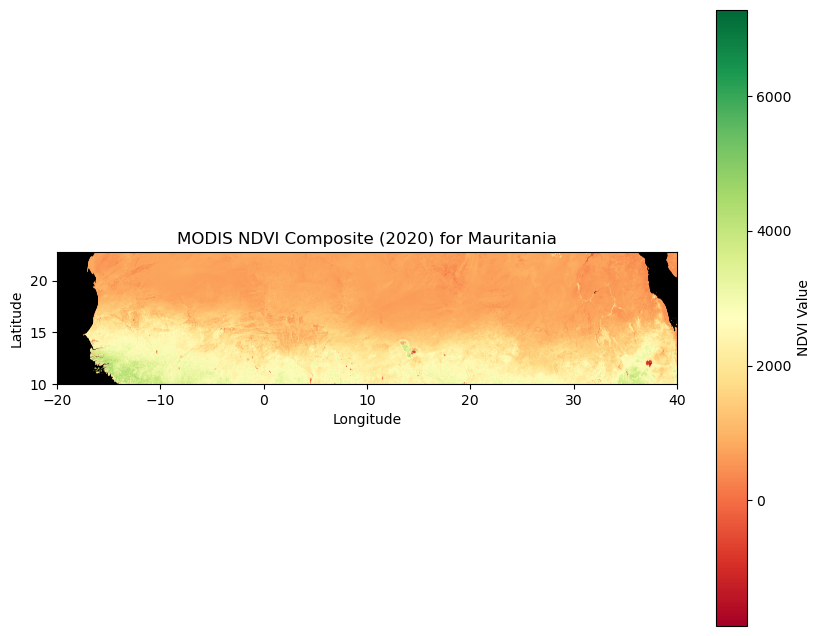

In [10]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib as mpl

# Replace 'MODIS_NDVI_2020.tif' with the path to your downloaded file.
tif_path = "../src/EVI/EVI_2022.tif"

# Open the GeoTIFF file
with rasterio.open(tif_path) as src:
    data = src.read(1)  # read the first band
    transform = src.transform
    nodata = src.nodata

# Optionally, mask out NoData values
import numpy as np
data = np.ma.masked_equal(data, nodata) if nodata is not None else data

# Create a plot
fig, ax = plt.subplots(figsize=(10, 8))

# Define a colormap; for NDVI, 'RdYlGn' is commonly used.
cmap = plt.cm.get_cmap('RdYlGn').copy()
cmap.set_bad(color='black')  # Masked values appear in black

# Plot the data using imshow for more control (and to get a mappable for the colorbar)
# Use rasterio.plot.plotting_extent to correctly georeference the image.
from rasterio.plot import plotting_extent
extent = plotting_extent(src)

img = ax.imshow(data, extent=extent, cmap=cmap)
ax.set_title("MODIS NDVI Composite (2020) for Mauritania")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Create a ScalarMappable for the colorbar with the correct normalization.
norm = mpl.colors.Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, label="NDVI Value")
plt.show()


C:\Users\loren\anaconda3\envs\StarthackG20\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'gadm41_MRT.gpkg': 'ADM_ADM_0' (default), 'ADM_ADM_1', 'ADM_ADM_2'. Specify layer parameter to avoid this warning.
  result = read_func(
C:\Users\loren\AppData\Local\Temp\ipykernel_23520\88536549.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn').copy()


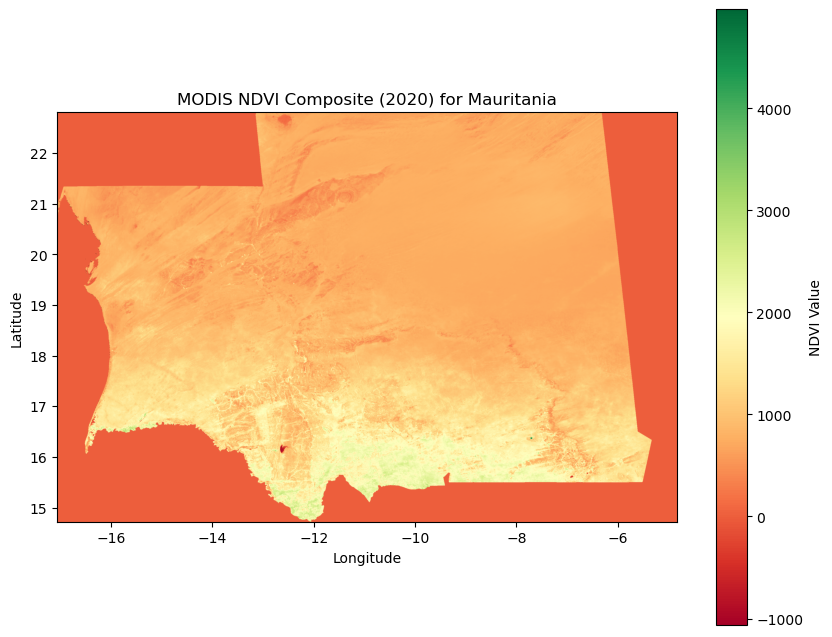

In [11]:
import rasterio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# 1. Load the Mauritania boundary (GeoPackage or Shapefile)
# Replace 'path/to/mauritania.gpkg' with the path to your Mauritania GeoPackage.
mauritania_gdf = gpd.read_file("../src/gadm41_MRT.gpkg")
# Ensure the boundary is in WGS84 (EPSG:4326)
mauritania_gdf = mauritania_gdf.to_crs("EPSG:4326")

# Convert to a list of GeoJSON geometries for rasterio.mask
shapes = [feature["geometry"] for feature in mauritania_gdf.__geo_interface__["features"]]

# 2. Open the exported raster (e.g., MODIS NDVI composite)
tif_path = "../src/EVI/EVI_2022.tif"  # Update with your file name/path
with rasterio.open(tif_path) as src:
    # Clip the raster to Mauritania boundary
    clipped_image, clipped_transform = rasterio.mask.mask(src, shapes, crop=True)
    clipped_meta = src.meta.copy()
    nodata = src.nodata

# Extract the first band (assuming a single-band raster)
data = clipped_image[0]

# Mask out the NoData values (if nodata is defined)
if nodata is not None:
    data = np.ma.masked_equal(data, nodata)

# 3. Plot the clipped data with a colorbar (legend)
fig, ax = plt.subplots(figsize=(10, 8))
# Use a colormap appropriate for NDVI (e.g., RdYlGn) and set masked values to black
cmap = plt.cm.get_cmap('RdYlGn').copy()
cmap.set_bad('black')

# Calculate the extent from the clipped transform
extent = (
    clipped_transform[2],
    clipped_transform[2] + clipped_transform[0] * data.shape[1],
    clipped_transform[5] + clipped_transform[4] * data.shape[0],
    clipped_transform[5]
)

img = ax.imshow(data, extent=extent, cmap=cmap)
ax.set_title("MODIS NDVI Composite (2020) for Mauritania")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Create a ScalarMappable for the colorbar using the data's range
norm = mpl.colors.Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

plt.colorbar(sm, ax=ax, label="NDVI Value")
plt.show()


C:\Users\loren\anaconda3\envs\StarthackG20\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'gadm41_MRT.gpkg': 'ADM_ADM_0' (default), 'ADM_ADM_1', 'ADM_ADM_2'. Specify layer parameter to avoid this warning.
  result = read_func(
C:\Users\loren\AppData\Local\Temp\ipykernel_23520\4089138084.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn').copy()


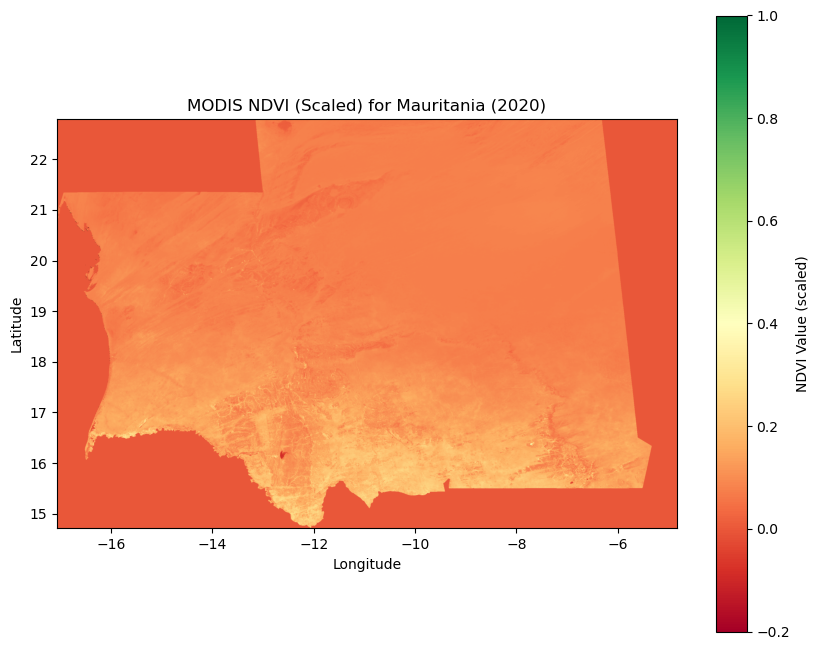

In [12]:
import rasterio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# 1. Load the Mauritania boundary
mauritania_gdf = gpd.read_file("../src/gadm41_MRT.gpkg").to_crs("EPSG:4326")
shapes = [feature["geometry"] for feature in mauritania_gdf.__geo_interface__["features"]]

# 2. Open the exported MODIS NDVI raster
tif_path = "../src/EVI/EVI_2022.tif"
with rasterio.open(tif_path) as src:
    clipped_image, clipped_transform = rasterio.mask.mask(src, shapes, crop=True)
    nodata = src.nodata
    meta = src.meta.copy()

data = clipped_image[0].astype(float)

# 3. If the data is raw MODIS NDVI, apply the scale factor (commonly 0.0001).
#    This brings values into a typical NDVI range of about -0.2 to 1.0.
scale_factor = 0.0001
data *= scale_factor

# Mask out NoData values
if nodata is not None:
    # The raw nodata value is still in the original scale,
    # so multiply that by the scale factor if needed:
    scaled_nodata = nodata * scale_factor
    mask = np.isclose(data, scaled_nodata)
else:
    mask = np.zeros_like(data, dtype=bool)

data_masked = np.ma.masked_array(data, mask=mask)

# 4. Define the plot extent using the transform
height, width = data_masked.shape
extent = (
    clipped_transform[2],
    clipped_transform[2] + clipped_transform[0] * width,
    clipped_transform[5] + clipped_transform[4] * height,
    clipped_transform[5]
)

# 5. Plot the data with a nice colormap and a sensible NDVI range
fig, ax = plt.subplots(figsize=(10, 8))

# 'RdYlGn' is a common colormap for NDVI; let's set masked pixels to black.
cmap = plt.cm.get_cmap('RdYlGn').copy()
cmap.set_bad('black')

# Typical NDVI range is about -0.2 to 1.0, but adjust as needed:
vmin, vmax = -0.2, 1.0

img = ax.imshow(
    data_masked,
    extent=extent,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax
)
ax.set_title("MODIS NDVI (Scaled) for Mauritania (2020)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Create a ScalarMappable for the colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, label="NDVI Value (scaled)")
plt.show()
